In [ ]:
DATASET_LINK='http://files.grouplens.org/datasets/movielens/ml-100k.zip'

In [ ]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

File ‘ml-100k.zip’ already there; not retrieving.

Archive:  ml-100k.zip


**EDA**

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Read users data
user_columns = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users_df = pd.read_csv('ml-100k/u.user', sep='|', names=user_columns)

# Read ratings data
ratings_columns = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_df = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_columns)
ratings_df.drop("unix_timestamp", inplace=True, axis=1)

# Read and clean movie data
def clean_title(title):
    return re.sub("[\(\[].*?[\)\]]", "", title)

def process_genre(series):
    genres = series.index[6:-2]

    text = []
    for i in genres:
        if series[i] == 1:
            text.append(i)
            break
    return ", ".join(text)

# Read genres
genre_df = pd.read_csv('ml-100k/u.genre', sep='|', encoding='latin-1')
genre_columns = ["unknown"] + list(genre_df[genre_df.columns[0]].values)

# Display the genre columns
print(genre_columns)

# Read movies data
movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies_df = pd.read_csv('ml-100k/u.item', sep='|', names=movie_columns + genre_columns, encoding='latin-1')

# Remove the issuing date from the movie title
movies_df['title'] = movies_df['title'].apply(clean_title)
movies_df['title'] = movies_df['title'].str.strip()

# Create a new column 'genre' by concatenating genres
movies_df['genre'] = movies_df.apply(process_genre, axis=1)

# Create a copy of the movie dataset and drop unnecessary columns
movies_red_df = movies_df.copy()
movies_red_df.drop(movies_red_df.columns[[2, 3, 4]], inplace=True, axis=1)
movies_red_df.drop(genre_columns, axis=1, inplace=True)

# Display the modified movie dataset
print(movies_red_df.head(5))

# Display the number of users, movies, and ratings
print("Users:", users_df.user_id.nunique())
print("Movies:", movies_df.movie_id.nunique())
print("Movies with ratings:", ratings_df.movie_id.nunique())
print("Users with ratings:", ratings_df.user_id.nunique())
print("Ratings:", ratings_df.shape[0])

# Plot users distribution by sex
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(x="sex", data=users_df, palette="Set2")
plt.title("Distribution of Users by Sex")
plt.show()

# Plot users age distribution grouped by sex
plt.figure(figsize=(12, 6))
sns.kdeplot(data=users_df, x="age", hue="sex", fill=True, palette="husl", common_norm=False)
plt.title("Users Age Distribution Grouped by Sex")
plt.show()

# Plot top 20 users' occupations
plt.figure(figsize=(14, 6))
sns.countplot(x="occupation", data=users_df, order=users_df['occupation'].value_counts().index[:20], palette="viridis")
plt.title("Top 20 User Occupations")
plt.xticks(rotation=45, ha="right")
plt.show()

# Display the number of unique occupations
print("Number of Occupations:", users_df.occupation.nunique())

# Plot users age distribution grouped by occupation
plt.figure(figsize=(14, 8))
sns.kdeplot(data=users_df, x="age", hue="occupation", fill=True, palette="Paired", common_norm=False, levels=20)
plt.title("Users Age Distribution Grouped by Occupation")
plt.show()

# Plot ratings distribution
plt.figure(figsize=(8, 6))
sns.countplot(x="rating", data=ratings_df, palette="coolwarm")
plt.title("Distribution of Ratings")
plt.show()

# Merge movies and ratings datasets
movie_ratings_df = movies_df.merge(ratings_df, on="movie_id", how="inner")

# Plot ratings per movie title (top 20 movies)
plt.figure(figsize=(14, 8))
sns.countplot(y="title", data=movie_ratings_df, order=movie_ratings_df['title'].value_counts().index[:20], palette="Set3")
plt.title("Ratings per Movie Title (Top 20 Movies)")
plt.show()

# Display movies with the best ratings
best_rated_movies = movie_ratings_df.sort_values(by="rating", ascending=False)[["title", "release_date", "genre", "rating"]].head(10)
print("Movies with Best Ratings:")
print(best_rated_movies)

# Count how many ratings each movie has
movie_ratings_agg_df = movie_ratings_df.groupby(["title"])["rating"].count().reset_index()
movie_ratings_agg_df.columns = ["title", "ratings_number"]

# Display movies with the most ratings
print("Movies with Most Ratings:")
print(movie_ratings_agg_df.sort_values(by="ratings_number", ascending=False).head(10))

# Merge the result back to the dataset
movie_ratings_df = movie_ratings_df.merge(movie_ratings_agg_df, on="title")

# Group by title and ratings_number, calculate mean of ratings
movie_ratings_agg_df = movie_ratings_df.groupby(["title", "ratings_number"])["rating"].mean().reset_index()
movie_ratings_agg_df.columns = ["title", "ratings_number", "ratings_mean"]

# Display movies with the best average ratings
print("Movies with Best Average Ratings:")
print(movie_ratings_agg_df.sort_values(by="ratings_mean", ascending=False).head(10))

# Select only movies with more than 400 ratings
sel_movie_ratings_df = movie_ratings_df.loc[movie_ratings_df.ratings_number > 400]

# Group by title and ratings_number, calculate mean of ratings
sel_movie_ratings_agg_df = sel_movie_ratings_df.groupby(["title", "ratings_number"])["rating"].mean().reset_index()
sel_movie_ratings_agg_df.columns = ["title", "ratings_number", "ratings_mean"]

# Display top movies with the best average ratings (more than 400 ratings)
print("Top Movies with Best Average Ratings (More than 400 Ratings):")
print(sel_movie_ratings_agg_df.sort_values(by="ratings_mean", ascending=False).head(10))

# Plot ratings number and ratings mean distribution (100K ratings)
plt.figure(figsize=(10, 8))
sns.kdeplot(data=movie_ratings_agg_df, x="ratings_number", y="ratings_mean", fill=True, cmap="YlGnBu", levels=20)
plt.title("Ratings Number and Ratings Mean Distribution (100K Ratings)")
plt.show()

# Plot ratings number and ratings mean distribution (only movies with more than 400 ratings)
plt.figure(figsize=(10, 8))
sns.kdeplot(data=sel_movie_ratings_agg_df, x="ratings_number", y="ratings_mean", fill=True, cmap="YlGnBu", levels=20)
plt.title("Ratings Number and Ratings Mean Distribution (Movies with More than 400 Ratings)")
plt.show()

# Plot movies genre distribution
plt.figure(figsize=(14, 8))
sns.countplot(y="genre", data=movies_df, order=movies_df['genre'].value_counts().index, palette="viridis")
plt.title("Movies Genre Distribution (from 1682 Movies)")
plt.show()

# Count ratings for each genre
genre_ratings_agg_df = movie_ratings_df.groupby(["genre"])["rating"].count().reset_index()
genre_ratings_agg_df.columns = ["genre", "ratings_number"]

# Display genre with most ratings
print("Genre with Most Ratings:")
print(genre_ratings_agg_df.sort_values(by="ratings_number", ascending=False).head(10))

# Plot ratings per movie genre (100K ratings)
plt.figure(figsize=(14, 6))
sns.barplot(x="ratings_number", y="genre", data=genre_ratings_agg_df, palette="plasma")
plt.title("Ratings per Movie Genre (100K Ratings)")
plt.show()

# Calculate average ratings for each genre
genre_ratings_mean_df = movie_ratings_df.groupby(["genre"])["rating"].mean().reset_index()
genre_ratings_mean_df.columns = ["genre", "ratings_average"]

# Display genre with highest mean ratings
print("Genre with Highest (Mean) Ratings:")
print(genre_ratings_mean_df.sort_values(by="ratings_average", ascending=False))

# Plot movie ratings average, grouped by genre (100K ratings)
plt.figure(figsize=(14, 6))
sns.barplot(x="ratings_average", y="genre", data=genre_ratings_mean_df, palette="plasma")
plt.title("Movie Ratings Average, Grouped by Genre (100K Ratings)")
plt.show()


**KNN**

In [ ]:
import collections
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import pairwise_distances

In [ ]:
film = pd.read_csv('ml-100k/u.item', sep='|', encoding='ISO-8859-1')


In [ ]:
film.columns = ['filmId', 'title', 'release date', 'video release date',
                'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',
                'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
                'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
                'Sci-Fi', 'Thriller', 'War', 'Western']
columns = ['release date', 'video release date',
           'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',
           'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
           'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
           'Sci-Fi', 'Thriller', 'War', 'Western']

In [ ]:
film = film.drop(columns, axis=1)

In [ ]:
rating = pd.read_csv('ml-100k/u1.base', sep='\t', encoding='ISO-8859-1')
rating.columns = ['userId', 'filmId', 'rating', 'timestamp']
rating = rating.drop(['timestamp'], axis=1)

In [ ]:
# Create a nested dictionary of each user with the filmIds and the ratings they provided
watched = collections.defaultdict(dict)
for i in rating.values.tolist():
    watched[i[0]][i[1]] = i[2]

In [ ]:
#Create a pivot table with index as userId, columns as filmId, values as rating
rating_pivot = rating.pivot(index='userId', columns='filmId', values='rating').fillna(0)

In [ ]:
# Convert the pivot table into a dense numpy array
rating_matrix = rating_pivot.values

In [ ]:
# Use Nearest Neighbors to find similar users
k_neighbors = 70
knn_users = NearestNeighbors(n_neighbors=k_neighbors, metric='cosine')
knn_users.fit(rating_matrix)

NearestNeighbors(metric='cosine', n_neighbors=70)

In [ ]:
# Get similarity matrix for users
user_similarity_matrix = 1 - pairwise_distances(rating_matrix, metric='cosine')

In [ ]:
# Use KNNImputer with 'nan_euclidean' metric on the similarity matrix
knn_imputer = KNNImputer(n_neighbors=5, metric='nan_euclidean')
imputed_similarity_matrix = knn_imputer.fit_transform(user_similarity_matrix)


In [ ]:
# Extract imputed values for user pairs present in u1.test
imputed_ratings = []
for i in rating.values.tolist():
    user1, user2 = i[0], i[1]
    if user1 < rating_matrix.shape[0] and user2 < rating_matrix.shape[0]:
        imputed_ratings.append(imputed_similarity_matrix[user1, user2])


In [ ]:
# Convert imputed ratings to numpy array for comparison
imputed_ratings = np.array(imputed_ratings)

In [ ]:
# Calculate evaluation metrics
mae_knn = mean_absolute_error(rating['rating'][:len(imputed_ratings)], imputed_ratings)
rmse_knn = np.sqrt(mean_squared_error(rating['rating'][:len(imputed_ratings)], imputed_ratings))

In [ ]:
print('Mean Absolute Error (MAE) using KNN: {:.2f}'.format(mae_knn))
print('Root Mean Squared Error (RMSE) using KNN : {:.2f}'.format(rmse_knn))

Mean Absolute Error (MAE) using KNN: 3.39
Root Mean Squared Error (RMSE) using KNN : 3.57


**K-DENSEST KNN**

In [ ]:
import collections
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

In [ ]:
# Load relevant files into DataFrame
movie = pd.read_csv('ml-100k/u.item', sep='|', encoding='ISO-8859-1')
movie.columns = ['filmId', 'title', 'release date', 'video release date',
                'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',
                'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
                'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
                'Sci-Fi', 'Thriller', 'War', 'Western']
columns = ['release date', 'video release date',
           'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',
           'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
           'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
           'Sci-Fi', 'Thriller', 'War', 'Western']
movie = movie.drop(columns, axis=1)

rating2 = pd.read_csv('ml-100k/u1.test', sep='\t', encoding='ISO-8859-1')
rating2.columns = ['userId', 'filmId', 'rating', 'timestamp']
rating2 = rating2.drop(['timestamp'], axis=1)

# Created a nested dictionary of each user with the filmIds and the ratings they provided
watched = collections.defaultdict(dict)
for i in rating2.values.tolist():
    watched[i[0]][i[1]] = i[2]

# Create a pivot table with index as userId, columns as filmId, values as rating
rating_pivot2 = rating2.pivot(index='userId', columns='filmId',
                            values='rating').fillna(0)
# Convert the pivot table into a sparse matrix
rating_matrix2 = csr_matrix(rating_pivot2.values)

# Initialize k nearest neighbors
knn2 = NearestNeighbors(metric='cosine', algorithm='brute')
knn2.fit(rating_matrix2)

# Change k to 70
k = 70

# Get 70-densest users
grouped = rating2.groupby('userId')['rating'].count().reset_index()
grouped.columns = ['userId', 'Density']
densest_users = grouped.sort_values(by='Density', ascending=False).head(k)

# Initialize variables for imputed matrix
imputed_matrix2 = np.zeros_like(rating_matrix2.toarray())

for user_id in densest_users['userId']:
    # Find nearest neighbors for each user
    user_index = user_id - 1

    # Find 17 nearest neighbors
    distances, indices = knn2.kneighbors(rating_pivot2.iloc[user_index, :].values.reshape(1, -1), n_neighbors=17)

    # Impute values for unwatched films
    for i in range(len(indices.flatten())):
        neighbor_index = indices.flatten()[i]
        imputed_matrix2[user_index, :] += rating_matrix2.toarray()[neighbor_index, :] * distances.flatten()[i]

# Check for NaN values and normalize only if the sum is non-zero
for i in range(imputed_matrix2.shape[0]):
    if np.sum(np.abs(imputed_matrix2[i, :])) != 0:
        imputed_matrix2[i, :] /= np.sum(np.abs(imputed_matrix2[i, :]))

# Calculate evaluation metrics
MAE_KDI = mean_absolute_error(rating_matrix2.toarray(), imputed_matrix2)
RSME_KDI = math.sqrt(mean_squared_error(rating_matrix2.toarray(), imputed_matrix2))

print('Mean Absolute Error (MAE) using K-Densest KNN: {:.2f}'.format(MAE_KDI))
print('Root Mean Squared Error (RMSE) using K-Densest KNN: {:.2f}'.format(RSME_KDI))


Mean Absolute Error (MAE) using K-Densest KNN: 0.11
Root Mean Squared Error (RMSE) using K-Densest KNN: 0.65


**GA**

In [ ]:
"""Settings file for the project."""

# Constants
NO_OF_FEATURES = 21
NO_OF_GENRES = 19

In [ ]:
import pandas as pd

# Load users
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')

# Load ratings
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, encoding='latin-1')

# Load genres
i_cols = ['movie_id', 'movie_title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=i_cols,
 encoding='latin-1')

# Merge users and ratings on user_id
movies_users_ratings = pd.merge(users, ratings, on='user_id')

# Merge movies_users_ratings and items on movie_id
items_merged = pd.merge(movies_users_ratings, items, on='movie_id')

In [ ]:
from itertools import count
import numpy as np

# Genre columns
genre_cols = ['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
          'Fantasy','Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

# Initialize numpy arrays
gr = np.zeros(NO_OF_GENRES)
gf = np.zeros(NO_OF_GENRES)
rgr = np.zeros(NO_OF_GENRES)
rgf = np.zeros(NO_OF_GENRES)
mrgf = np.zeros(NO_OF_GENRES)

# tr - total_ratings
# gr - genre_rating
# gf - genre_frequency
# rgr - realtive_genre_ratings
# rgf - relative_genre_frequency
# mrgf - modified_relative_genre_frequency
# gim - genre interestingness measure


def total_rating(i):
    """Get total of given or particular rating."""
    total = 0
    for k in count['rating']:
        total = total + k
    return total


def genre_rating(movies):
    """Get genre rating for movies"""
    for i in range(0, NO_OF_GENRES):
        gr[i] = np.dot(movies['rating'], movies[genre_cols[i]])
    return gr


def genre_frequency(movies):
    """Get genre frequency for all the movies i.e. how many movies have a particular genre."""
    for i in range(0, NO_OF_GENRES):
        gf[i] = movies[genre_cols[i]].sum()
    return gf


def relative_genre_rating(gr, tr):
    """Relative Genre Rating= Genre Ratings/ Total Rating"""
    for i in range(0, NO_OF_GENRES):
        rgr[i] = gr[i] / tr
    return rgr


def relative_genre_frequency(gf, tf):
    """Relative Genre Frequency=Genre Frequency/Total Frequency"""
    for i in range(0, NO_OF_GENRES):
        rgf[i] = gf[i] / tf
    return rgf


def add_for_mrgf(movies):
    total = np.zeros(NO_OF_GENRES)
    for i in range(0, NO_OF_GENRES):
        m_t = movies.loc[movies[genre_cols[i]] == 1]
        for j in m_t['rating']:
            total[i] = total[i] + (j - 2)
    return total


def modified_relative_genre_frequency(movies, tf):
    """Modified Relative Genre Frequency = add_for_mrgf/(3*Total Frequency)"""
    added = add_for_mrgf(movies)
    for i in range(0, NO_OF_GENRES):
        mrgf[i] = (added[i]) / (3.0 * tf)
    return mrgf


def gim_final(user_movies, i):
    """Get GIM of movies of particular user"""

    gim_list = [0] * NO_OF_FEATURES
    tf = user_movies.shape[0]
    # print tf
    tr = 0
    for k in user_movies['rating']:
        tr = tr + k
    movies = user_movies.loc[user_movies['rating'] >= 3.0]

    gr = genre_rating(movies)
    # gf = genre_frequency(movies)
    rgr = relative_genre_rating(gr, tr)
    # rgf = relative_genre_frequency(gf, tf)
    mrgf = modified_relative_genre_frequency(movies, tf)

    nf = 5.0
    for i in range(0, NO_OF_GENRES):
        gim_list[i] = (2 * nf * mrgf[i] * rgr[i]) / (rgr[i] + mrgf[i])
    gim_list = np.nan_to_num(gim_list)
    return gim_list

In [ ]:
def cost_function(actual_ratings, predicted_ratings):
    """Cost function to optimize using genetic method."""
    ms = sum(abs(np.array(predicted_ratings) - np.array(actual_ratings)))
    return ms / len(actual_ratings)

In [ ]:
# Constants
INITIAL_POPULATION=50
MUTATION_RATE=0.05
NUM_OF_GENERATIONS=50
FEATURE_LENGTH=21
WINNER_PER_GEN=5

def genetic_optimize(actual_ratings, predicted_ratings):
    """Get genetic feature weights using crossover and mutation."""

    # Generate initial binary population
    cur_gen_pop = np.random.randint(2, size=(INITIAL_POPULATION, FEATURE_LENGTH))
    next_gen_pop = np.zeros((cur_gen_pop.shape[0], cur_gen_pop.shape[1]))
    fitness_vector = np.zeros((INITIAL_POPULATION, 2))

    for i in range(NUM_OF_GENERATIONS):

        fitness_vector = np.array([np.array([x, cost_function(actual_ratings, predicted_ratings)]) for x in range(INITIAL_POPULATION)])
        # e.g. [0, 0.11] means that the 0th element in cur_gen_pop (first solution) has an error of 0.11

        # create a winners array of size winner*solution
        winners = np.zeros((WINNER_PER_GEN, FEATURE_LENGTH))
        for n in range(len(winners)):
            selected = np.random.choice(range(len(fitness_vector)), int(WINNER_PER_GEN/2),
                                        replace=False)  # select random indexes from pop

            wnr = np.argmin(fitness_vector[selected, 1])  # select one index with min fitness error (tournament)
            winners[n] = cur_gen_pop[int(fitness_vector[selected[wnr]][0])]  # add to winner population

        next_gen_pop[:len(winners)] = winners  # populate new gen with winners

        # mating using crossover via permutation
        next_gen_pop[len(winners):] = np.array(
            [np.array(
                np.random.permutation(np.repeat(winners[:, x], ((INITIAL_POPULATION - len(winners)) / len(winners)), axis=0)))
             for x in range(winners.shape[1])]).T  # Populate the rest of the generation with offspring of mating pairs

        # random mutation
        next_gen_pop = np.multiply(next_gen_pop, np.matrix(
            [np.float(np.random.normal(0, 2, 1)) if np.random.random() < MUTATION_RATE else 1 for x in
             range(next_gen_pop.size)]).reshape(next_gen_pop.shape))
        cur_gen_pop = next_gen_pop

    best_soln = np.array(cur_gen_pop[np.argmin(fitness_vector[:, 1])])
    return best_soln

In [ ]:
class Age:
    """Define methods to get fuzzy values of given age in three sets i.e. young, middle, and old."""

    def __int__(self):
        pass

    def young(self, age):
        """Get value for young fuzzy set for given age."""
        if age < 20.0:
            return 1.0
        elif 20.0 <= age < 35.0:
            return float((35-age)/15.0)
        else:
            return 0.0

    def middle(self, age):
        """Get value for middle fuzzy set for given age."""
        if age <= 20 or age > 60:
            return 0.0
        elif 20 < age <= 35:
            return float(age-20)/15
        elif 35 < age <= 45:
            return 1.0
        elif 45 < age <= 60:
            return (60-age)/15.0

    def old(self, age):
        """get value for old fuzzy set for given age."""
        if age <= 45:
            return 0.0
        elif 45 < age <= 60:
            return (age-45.0)/15
        else:
            return 1.0

    def get_fuzzy_set(self, age):
        """Get fuzzy set values of given age."""
        return [self.young(age),
                self.middle(age),
                self.old(age)]

class GIM:
    """GIM- Genre Interestingness Measure"""

    def __init__(self):
        pass

    def gim_a(self, gim, i):
        """Method to get fuzzy set value for very_bad, bad, average, good."""
        if gim <= i - 2 or gim > i:
            return 0.0
        elif i - 2 < gim <= i - 1:
            return gim - i + 2.0
        elif i - 1 < gim <= i:
            return float(i - gim)

    def very_bad(self, gim):
        if gim <= 1.0:
            return 1.0
        else:
            return 0.0

    def bad(self, gim):
        return self.gim_a(gim, 2.0)

    def average(self, gim):
        return self.gim_a(gim, 3.0)

    def good(self, gim):
        return self.gim_a(gim, 4.0)

    def very_good(self, gim):
        return self.gim_a(gim, 5.0)

    def excellent(self, gim):
        if gim <=4.0:
            return 0.0
        else:
            return (gim-4.0)

    def get_fuzzy_set(self, gim_value):
        """Get fuzzy set of gim(list of values) based on given gim value."""
        return [self.very_bad(gim_value),
                self.bad(gim_value),
                self.average(gim_value),
                self.good(gim_value),
                self.very_good(gim_value),
                self.excellent(gim_value)]

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import operator

# Constants
WEIGHTS=np.random.rand(NO_OF_FEATURES)
NO_OF_ITERATIONS=10
NO_OF_NEIGHBOURS=20

# namespace items_merged from load_data file
# items_merged = load_data.items_merged

# Create objects for Age and GIM to use for fuzzy sets
age = Age()
gim_obj = GIM()

m_cols = ['unknown', 'Action', 'Adventure',
          'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age',
          'user_id']

# Initialize empty dataFrames for active and passive users
model_data_active_users = pd.DataFrame(columns=m_cols)
model_data_passive_users = pd.DataFrame(columns=m_cols)


def euclidean_dist(list_a, list_b):
    """Return the Euclidean distance between two array elements."""
    return np.linalg.norm(np.array(list_a) - np.array(list_b))


def fuzzy_dist(first_point, second_point, fuzzy_set_first_point, fuzzy_set_second_point):
    """Returns fuzzy distance between two values and their fuzzy sets."""
    return abs(first_point - second_point) * euclidean_dist(fuzzy_set_first_point, fuzzy_set_second_point)


def fuzzy_distance(ui, uj):
    """Returns fuzzy distance between given points."""

    fuzzy_dis = [0] * NO_OF_FEATURES

    # Get fuzzy set values for movie genres
    for i in range(0, NO_OF_GENRES):
        ui_gim = gim_obj.get_fuzzy_set(ui[i])
        uj_gim = gim_obj.get_fuzzy_set(uj[i])
        fuzzy_dis[i] = fuzzy_dist(ui[i], uj[i], ui_gim, uj_gim)

    # Get fuzzy set values for age
    ui_gim = age.get_fuzzy_set(ui[i])
    uj_gim = age.get_fuzzy_set(uj[i])
    fuzzy_dis[i] = fuzzy_dist(ui[i], uj[i], ui_gim, uj_gim)

    # adding user_id of second user
    fuzzy_dis[NO_OF_FEATURES-1] = uj['user_id']
    return fuzzy_dis


def get_neighbours(model_active_users, model_passive_users):

    # Save active users and its neighbours in a data-frame with active users' id as column name
    user_neighbours= pd.DataFrame(columns=model_active_users['user_id'])

    # Iterate over active users model and save neighbours of each active users in user_neighbours
    for _, value in model_active_users.iterrows():
        j = 0
        fuzzy_vec = []
        for _, value_p in model_passive_users.iterrows():
            fuzzy_vec.append(fuzzy_distance(value, value_p))

            fuzzy_gen_dist = np.sum(np.multiply(WEIGHTS[:-1], np.array(fuzzy_vec[j][:-1]))) ** 0.5

            fuzzy_vec[j] = [fuzzy_gen_dist, fuzzy_vec[j][-1]]

            j = j + 1

        user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]
    return user_neighbours


def model_for_users(users_data):
    """Create model for given users data i.e. merged movies, items, and users

    Args:
        users_data: DataFrame of merged movies, items, and users based on movie_id
    """

    i = 0
    model_data_for_users = pd.DataFrame(columns=m_cols)

    for _, curr_value in users_data.iterrows():

        # Get user movies based on user
        user_movies = items_merged.loc[items_merged['user_id'] == curr_value['user_id']]

        # Get feature list for all movies of one user
        feature_array = gim_final(user_movies, curr_value['user_id'])
        feature_array[NO_OF_GENRES] = curr_value['age']
        feature_array[NO_OF_GENRES + 1] = curr_value['user_id']

        # Save current feature values in model data
        model_data_for_users.loc[i] = feature_array
        i = i + 1
    return model_data_for_users


def recommend(nearest_neighbours, test_users_data):
    """Recommend rating for given movies i.e. test_examples based on nearest neighbours.

    Also return actual and predicated ratings for testing users
    """
    predicated_rat=[]
    actual_rat = []
    for key, item in test_users_data.iterrows():
        m_id = item['movie_id']
        n_ratings = []
        for i in nearest_neighbours:

            # Get items or movie details reviewed by neighbour i with given m_id
            temp = items_merged.loc[items_merged['user_id'] == i].loc[items_merged['movie_id'] == m_id]
            for k, it in temp.iterrows():
                n_ratings.append(it['rating'])
        predicated_rat.append(float(sum(n_ratings)) / len(n_ratings) if len(n_ratings) else 0)
        actual_rat.append(item['rating'])
    return actual_rat, predicated_rat

# Users who has rated movies at least 60 movies
top_users = items_merged.groupby('user_id').size().sort_values(ascending=False)[:497]

model_error_GA = []

In [ ]:
# Train model for given iterations
for i in range(0, NO_OF_ITERATIONS):

    # Get random 10% of the top_users as active users and remaining are passive users
    active_users = top_users.sample(frac=0.10)

    # Random 34% of active users will be used for training and 66% users for testing purpose.
    training_active_users = active_users.sample(frac=0.34)
    #testing_active_users = active_users.drop(training_active_users.index)

    # passive_users will be used as training examples
    passive_users = top_users.drop(active_users.index)

    # Get active and passive users' data from merged movies, items, and users
    training_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][:10]
    test_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][10:]
    passive_users_data = items_merged.loc[items_merged['user_id'].isin(passive_users)][:10]

    # Get model for active users
    model_data_active_users = model_for_users(training_active_users_data)

    # Get model for passive users
    model_data_passive_users = model_for_users(passive_users_data)

    # Get neighbour users of active users
    active_users_neighbours = get_neighbours(model_data_active_users, model_data_passive_users)

    # Recommend users based on neighbours
    actual_ratings, predicated_ratings=recommend(active_users_neighbours, test_active_users_data)

    # Get error for predictions of test users
    cur_error = cost_function(actual_ratings, predicated_ratings)

    # Optimize weights using genetic algorithm approach and update weighs
    WEIGHTS = genetic_optimize(actual_ratings, predicated_ratings).flatten()

    # Add current iteration error to model error for MAE of the model
    model_error_GA.append(cost_function(actual_ratings, predicated_ratings))

    # Log details for current iteration
    print("Iteration : ", i)
    print("Error: ", cur_error)
    #print('Weights after iteration is: ', WEIGHTS)

MAE_GA = sum(model_error_GA)/len(model_error_GA)
print("Mean absolute error for GA: ", MAE_GA)

Iteration :  0
Error:  0.7651045012335335
Iteration :  1
Error:  0.7997048515034124
Iteration :  2
Error:  0.8195176294561547
Iteration :  3
Error:  0.606257477865518
Iteration :  4
Error:  0.9554628687051492
Iteration :  5
Error:  0.7933189087600848
Iteration :  6
Error:  0.9882224570880541
Iteration :  7
Error:  0.7705399592483584
Iteration :  8
Error:  0.8121113758532181
Iteration :  9
Error:  0.8800027793218461
Mean absolute error for GA:  0.7879107514690673


**PSO**

In [ ]:
def PSO(num_particles=30, max_iter=100, w=0.5, c1=1, c2=2):

    #finalizing the dimension of solution space
    dim = FEATURE_LENGTH

    # Initialize particles and velocities
    particles = np.random.uniform(0, 1, (30, 21))
    velocities = np.zeros((30, 21))

    # Initialize the best positions and fitness values
    best_positions = np.copy(particles)
    best_fitness = np.array([cost_function(actual_ratings, predicted_ratings) for p in (particles)])
    swarm_best_position = best_positions[np.argmin(best_fitness)]
    swarm_best_fitness = np.min(best_fitness)

    # Iterate through the specified number of iterations, updating the velocity and position of each particle at each iteration
    for i in range(int(max_iter[0])):
        # Update velocities
        r1 = np.random.uniform(0, 1, (30, 21))
        r2 = np.random.uniform(0, 1, (30, 21))
        velocities = w * velocities + c1 * r1 * (best_positions - particles) + c2 * r2 * (swarm_best_position - particles)

        # Update positions
        particles += velocities

        # Evaluate fitness of each particle
        fitness_values = np.array([cost_function(actual_ratings, predicted_ratings) for p in (particles)])

        # Update best positions and fitness values
        improved_indices = np.where(fitness_values < best_fitness)
        best_positions[improved_indices] = particles[improved_indices]
        best_fitness[improved_indices] = fitness_values[improved_indices]
        if np.min(fitness_values) < swarm_best_fitness:
            swarm_best_position = particles[np.argmin(fitness_values)]
            swarm_best_fitness = np.min(fitness_values)

    # Return the best solution found by the PSO algorithm
    return swarm_best_position, swarm_best_fitness

model_error_PSO = []

In [ ]:
# Train model for given iterations
for i in range(0, NO_OF_ITERATIONS):

    # Get random 10% of the top_users as active users and remaining are passive users
    active_users = top_users.sample(frac=0.10)

    # Random 34% of active users will be used for training and 66% users for testing purpose.
    training_active_users = active_users.sample(frac=0.34)
    #testing_active_users = active_users.drop(training_active_users.index)

    # passive_users will be used as training examples
    passive_users = top_users.drop(active_users.index)

    # Get active and passive users' data from merged movies, items, and users
    training_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][:10]
    test_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][10:]
    passive_users_data = items_merged.loc[items_merged['user_id'].isin(passive_users)][:10]

    # Get model for active users
    model_data_active_users = model_for_users(training_active_users_data)

    # Get model for passive users
    model_data_passive_users = model_for_users(passive_users_data)

    # Get neighbour users of active users
    active_users_neighbours = get_neighbours(model_data_active_users, model_data_passive_users)

    # Recommend users based on neighbours
    actual_ratings, predicted_ratings=recommend(active_users_neighbours, test_active_users_data)

    # Get error for predictions of test users
    cur_error = cost_function(actual_ratings, predicted_ratings)

    # Optimize weights using genetic algorithm approach and update weighs
    WEIGHTS, cost_func = PSO(actual_ratings, predicted_ratings)

    # Add current iteration error to model error for MAE of the model
    model_error_PSO.append(cost_function(actual_ratings, predicted_ratings))

    # Log details for current iteration
    print("Iteration : ", i)
    print("Error: ", cur_error)
    #print('Weights after iteration is: ', WEIGHTS)

MAE_PSO = sum(model_error_PSO)/len(model_error_PSO)
print("Mean absolute error for PSO: ", MAE_PSO)

Iteration :  0
Error:  1.438655666945141
Iteration :  1
Error:  0.8250369604523156
Iteration :  2
Error:  0.7674710808922695
Iteration :  3
Error:  0.9847383875425176
Iteration :  4
Error:  0.5874242546117551
Iteration :  5
Error:  0.8807395864749837
Iteration :  6
Error:  0.9465469998142305
Iteration :  7
Error:  0.824535812267294
Iteration :  8
Error:  0.8026479597687027
Iteration :  9
Error:  0.8495640374177156
Mean absolute error for PSO:  0.8752089964635309


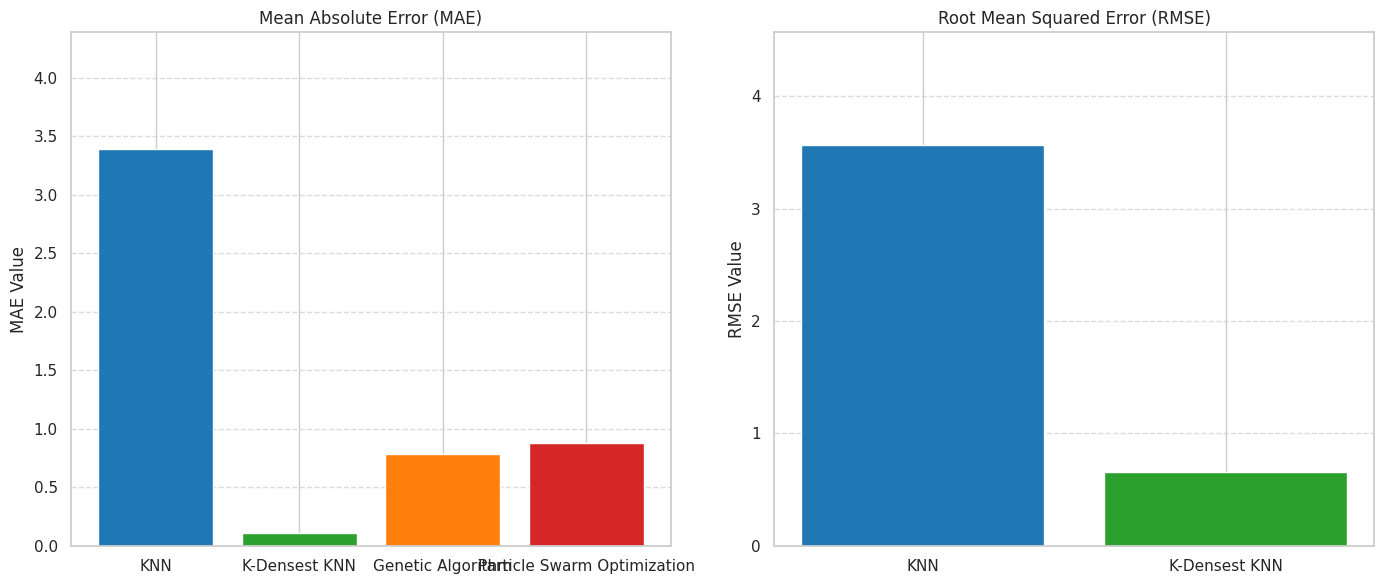

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual data)
mae_values = [mae_knn, MAE_KDI, MAE_GA, MAE_PSO]
rmse_values = [rmse_knn, RSME_KDI]  # Add other RMSE values if available
algorithms = ['KNN', 'K-Densest KNN', 'Genetic Algorithm', 'Particle Swarm Optimization']

# Set a custom color palette for better visibility
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']

# Set a larger font size for better readability
plt.rcParams.update({'font.size': 12})

# Plotting MAE and RMSE
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plotting MAE
axes[0].bar(algorithms, mae_values, color=colors)
axes[0].set_title('Mean Absolute Error (MAE)')
axes[0].set_ylabel('MAE Value')
axes[0].set_ylim(0, max(mae_values) + 1)  # Adjust the y-axis limit if needed
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plotting RMSE
axes[1].bar(algorithms[:len(rmse_values)], rmse_values, color=colors)
axes[1].set_title('Root Mean Squared Error (RMSE)')
axes[1].set_ylabel('RMSE Value')
axes[1].set_ylim(0, max(rmse_values) + 1)  # Adjust the y-axis limit if needed
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
